In [ ]:
!pip install transformers datasets peft bitsandbytes accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LOAD MODEL

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="auto")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

### BUILD PROMPT

In [ ]:
def build_prompt(text):
    return f"""Phân loại tin tức.

Chỉ trả lời duy nhất 1 số:
0 = Tin thật
1 = Tin giả

Chỉ ghi số, không cần giải thích.

### Ví dụ 1:
Tin tức: "Chính phủ Việt Nam vừa ban hành chính sách hỗ trợ người dân bị ảnh hưởng bởi bão lũ."
Đáp án: 0

### Ví dụ 2:
Tin tức: "Ngài Thẩm phán này mà giữ chức Chánh cao cao thì công an các trại tù chắc thất nghiệp dài dài"
Đáp án: 1

### Ví dụ 3:
Tin tức: "Vụ Trường quốc tế Singapore thu 80% học phí khi dạy online: Không được phép khi chưa thoả thuận được với phụ huynh"
Đáp án: 0

### Ví dụ 4:
Tin tức: "Bannon thẳng thừng chỉ trích Trung Quốc khiến truyền thông Trung Quốc gây chiến với ông!"
Đáp án: 1

Tin: "{text}"
Đáp án:"""


### CLASSIFY NEWS

In [ ]:
import torch

def classify(text):
    prompt = build_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=False
        )

    # Giải mã toàn bộ output
    decoded_full = tokenizer.decode(output[0], skip_special_tokens=True)
    # print("===== FULL OUTPUT (bao gồm prompt + sinh): =====")
    # print(decoded_full)

    decoded_only = tokenizer.decode(output[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()
    # print("===== CHỈ PHẦN MODEL SINH RA: =====")
    # print(decoded_only)

    # Chỉ lấy token đầu tiên (số 1 or 0), cắt toàn bộ giải thích sau
    first_token = decoded_only[0] if decoded_only and decoded_only[0] in ["0", "1"] else None
    print(">>> Label trích ra:", first_token)

    # Giải phóng bộ nhớ GPU
    del inputs, output
    torch.cuda.empty_cache()

    return first_token


classify('''
Rapper Bình Gold bị bắt vì tội cướp tài sản
''')


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


'0'

### PREDICT AND SAVE RESULT

In [ ]:
import pandas as pd
from tqdm import tqdm

# Đọc file
df = pd.read_csv('/content/drive/MyDrive/dataset/news/test.csv')

# Phân loại từng bài báo
tqdm.pandas()
df["predict"] = df["post_message"].progress_apply(classify)

# Lưu ra file mới
df.to_csv("prediction_fewshot.csv", index=False)

  0%|          | 2/486 [00:02<09:14,  1.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  1%|          | 3/486 [00:04<12:51,  1.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  1%|          | 4/486 [00:09<23:10,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  1%|          | 5/486 [00:14<29:39,  3.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  1%|          | 6/486 [00:19<32:43,  4.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  1%|▏         | 7/486 [00:22<30:13,  3.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  2%|▏         | 8/486 [00:30<40:58,  5.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  2%|▏         | 9/486 [00:34<37:45,  4.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  2%|▏         | 10/486 [00:41<41:16,  5.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  2%|▏         | 11/486 [00:44<35:55,  4.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  2%|▏         | 12/486 [00:46<30:32,  3.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  3%|▎         | 13/486 [00:48<26:33,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  3%|▎         | 14/486 [01:03<53:03,  6.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  3%|▎         | 15/486 [01:06<45:42,  5.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  3%|▎         | 16/486 [01:13<46:36,  5.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  3%|▎         | 17/486 [01:15<37:46,  4.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  4%|▎         | 18/486 [01:17<31:34,  4.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  4%|▍         | 19/486 [01:19<27:15,  3.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  4%|▍         | 20/486 [01:21<24:08,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  4%|▍         | 21/486 [01:27<30:36,  3.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  5%|▍         | 22/486 [01:32<32:04,  4.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  5%|▍         | 23/486 [01:37<33:14,  4.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  5%|▍         | 24/486 [01:42<34:39,  4.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  5%|▌         | 25/486 [01:45<31:10,  4.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  5%|▌         | 26/486 [01:47<27:01,  3.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  6%|▌         | 27/486 [01:49<23:18,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  6%|▌         | 28/486 [01:54<28:09,  3.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  6%|▌         | 29/486 [02:01<35:44,  4.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  6%|▌         | 30/486 [02:06<36:38,  4.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  6%|▋         | 31/486 [02:10<35:14,  4.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  7%|▋         | 32/486 [02:13<29:44,  3.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  7%|▋         | 33/486 [02:16<28:45,  3.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  7%|▋         | 34/486 [02:19<25:21,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  7%|▋         | 35/486 [02:21<22:47,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  7%|▋         | 36/486 [02:23<21:43,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  8%|▊         | 37/486 [02:26<20:08,  2.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  8%|▊         | 38/486 [02:30<24:16,  3.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  8%|▊         | 39/486 [02:34<24:48,  3.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


  8%|▊         | 40/486 [02:54<1:03:03,  8.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  8%|▊         | 41/486 [02:58<53:16,  7.18s/it]  The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  9%|▊         | 42/486 [03:01<42:08,  5.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  9%|▉         | 43/486 [03:03<34:26,  4.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  9%|▉         | 44/486 [03:07<32:44,  4.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  9%|▉         | 45/486 [03:10<30:23,  4.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


  9%|▉         | 46/486 [03:16<34:03,  4.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 10%|▉         | 47/486 [03:18<28:39,  3.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 10%|▉         | 48/486 [03:20<24:52,  3.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 10%|█         | 49/486 [03:23<22:31,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 10%|█         | 50/486 [03:26<22:28,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 10%|█         | 51/486 [03:28<21:25,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 11%|█         | 52/486 [03:32<22:36,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 11%|█         | 53/486 [03:40<32:44,  4.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 11%|█         | 54/486 [03:47<39:23,  5.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 11%|█▏        | 55/486 [03:50<32:26,  4.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 12%|█▏        | 56/486 [03:58<41:08,  5.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 12%|█▏        | 57/486 [04:03<38:07,  5.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 12%|█▏        | 58/486 [04:07<36:07,  5.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 12%|█▏        | 59/486 [04:10<31:40,  4.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 12%|█▏        | 60/486 [04:12<26:10,  3.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 13%|█▎        | 61/486 [04:18<30:03,  4.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 13%|█▎        | 62/486 [04:20<25:40,  3.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 13%|█▎        | 63/486 [04:24<26:57,  3.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 13%|█▎        | 64/486 [04:26<23:31,  3.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 13%|█▎        | 65/486 [04:29<21:17,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 14%|█▎        | 66/486 [04:33<24:31,  3.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 14%|█▍        | 67/486 [04:36<21:47,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 14%|█▍        | 68/486 [04:38<19:53,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 14%|█▍        | 69/486 [04:42<23:00,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 14%|█▍        | 70/486 [04:45<22:27,  3.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 15%|█▍        | 71/486 [04:47<20:21,  2.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 15%|█▍        | 72/486 [04:49<18:10,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 15%|█▌        | 73/486 [04:52<17:17,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 15%|█▌        | 74/486 [04:54<17:24,  2.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 15%|█▌        | 75/486 [05:02<28:56,  4.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 16%|█▌        | 76/486 [05:05<24:46,  3.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 16%|█▌        | 77/486 [05:08<24:22,  3.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 16%|█▌        | 78/486 [05:10<21:44,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 16%|█▋        | 79/486 [05:16<25:43,  3.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 16%|█▋        | 80/486 [05:19<24:24,  3.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 17%|█▋        | 81/486 [05:24<28:39,  4.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 17%|█▋        | 82/486 [05:29<29:24,  4.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 17%|█▋        | 83/486 [05:34<31:21,  4.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 17%|█▋        | 84/486 [05:37<26:34,  3.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 17%|█▋        | 85/486 [05:42<28:17,  4.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 18%|█▊        | 86/486 [05:47<29:46,  4.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 18%|█▊        | 87/486 [05:49<25:27,  3.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 18%|█▊        | 88/486 [05:51<22:30,  3.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 18%|█▊        | 89/486 [05:55<22:54,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 19%|█▊        | 90/486 [05:57<20:22,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 19%|█▊        | 91/486 [06:02<22:46,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 19%|█▉        | 92/486 [06:04<20:33,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 19%|█▉        | 93/486 [06:08<22:46,  3.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 19%|█▉        | 94/486 [06:13<25:41,  3.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 20%|█▉        | 95/486 [06:15<22:27,  3.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 20%|█▉        | 96/486 [06:20<24:10,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 20%|█▉        | 97/486 [06:26<29:41,  4.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 20%|██        | 98/486 [06:29<25:11,  3.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 20%|██        | 99/486 [06:40<39:15,  6.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 21%|██        | 100/486 [06:45<37:29,  5.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 21%|██        | 101/486 [06:47<30:28,  4.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 21%|██        | 102/486 [06:51<28:24,  4.44s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 21%|██        | 103/486 [06:57<31:23,  4.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 21%|██▏       | 104/486 [06:59<26:10,  4.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 22%|██▏       | 105/486 [07:03<24:58,  3.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 22%|██▏       | 106/486 [07:07<24:29,  3.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 22%|██▏       | 107/486 [07:11<26:21,  4.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 22%|██▏       | 108/486 [07:14<22:34,  3.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 22%|██▏       | 109/486 [07:16<19:56,  3.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 23%|██▎       | 110/486 [07:22<26:17,  4.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 23%|██▎       | 111/486 [07:25<23:15,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 23%|██▎       | 112/486 [07:36<36:55,  5.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 23%|██▎       | 113/486 [07:38<29:55,  4.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 23%|██▎       | 114/486 [07:41<25:01,  4.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 24%|██▎       | 115/486 [07:43<21:33,  3.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 24%|██▍       | 116/486 [07:45<19:12,  3.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 24%|██▍       | 117/486 [07:50<23:14,  3.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 24%|██▍       | 118/486 [07:53<20:18,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 24%|██▍       | 119/486 [07:55<18:20,  3.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 25%|██▍       | 120/486 [07:59<21:13,  3.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 25%|██▍       | 121/486 [08:11<36:41,  6.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 25%|██▌       | 122/486 [08:14<29:36,  4.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 25%|██▌       | 123/486 [08:19<30:07,  4.98s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 26%|██▌       | 124/486 [08:21<24:29,  4.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 26%|██▌       | 125/486 [08:26<26:48,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 26%|██▌       | 126/486 [08:33<30:29,  5.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 26%|██▌       | 127/486 [08:38<30:56,  5.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 26%|██▋       | 128/486 [08:41<26:59,  4.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 27%|██▋       | 129/486 [08:43<22:36,  3.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 27%|██▋       | 130/486 [08:45<19:42,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 27%|██▋       | 131/486 [08:48<17:42,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 27%|██▋       | 132/486 [08:53<21:52,  3.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 27%|██▋       | 133/486 [08:55<19:21,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 28%|██▊       | 134/486 [09:00<22:19,  3.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 28%|██▊       | 135/486 [09:06<25:06,  4.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 28%|██▊       | 136/486 [09:08<21:40,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 28%|██▊       | 137/486 [09:10<19:02,  3.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 28%|██▊       | 138/486 [09:13<17:07,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 29%|██▊       | 139/486 [09:15<15:53,  2.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 29%|██▉       | 140/486 [09:17<15:32,  2.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 29%|██▉       | 141/486 [09:20<14:38,  2.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 29%|██▉       | 142/486 [09:24<16:55,  2.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 29%|██▉       | 143/486 [09:25<15:06,  2.64s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 30%|██▉       | 144/486 [09:37<29:40,  5.21s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 30%|██▉       | 145/486 [09:39<24:32,  4.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 30%|███       | 146/486 [09:41<20:53,  3.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 30%|███       | 147/486 [09:46<23:34,  4.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 30%|███       | 148/486 [09:51<24:11,  4.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 31%|███       | 149/486 [09:53<20:39,  3.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 31%|███       | 150/486 [09:56<19:48,  3.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 31%|███       | 151/486 [10:12<40:29,  7.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 31%|███▏      | 152/486 [10:15<32:42,  5.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 31%|███▏      | 153/486 [10:28<44:33,  8.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 32%|███▏      | 154/486 [10:30<34:49,  6.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 32%|███▏      | 155/486 [10:38<36:54,  6.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 32%|███▏      | 156/486 [10:40<29:35,  5.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 32%|███▏      | 157/486 [10:43<24:28,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 33%|███▎      | 158/486 [10:45<20:44,  3.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 33%|███▎      | 159/486 [10:47<18:04,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 33%|███▎      | 160/486 [10:50<16:50,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 33%|███▎      | 161/486 [10:55<20:17,  3.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 33%|███▎      | 162/486 [10:59<21:36,  4.00s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 34%|███▎      | 163/486 [11:07<26:45,  4.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 34%|███▎      | 164/486 [11:09<22:52,  4.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 34%|███▍      | 165/486 [11:12<19:33,  3.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 34%|███▍      | 166/486 [11:15<19:14,  3.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 34%|███▍      | 167/486 [11:20<21:20,  4.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 35%|███▍      | 168/486 [11:28<26:54,  5.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 35%|███▍      | 169/486 [11:33<27:50,  5.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 35%|███▍      | 170/486 [11:36<23:02,  4.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 35%|███▌      | 171/486 [11:46<32:12,  6.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 35%|███▌      | 172/486 [11:49<26:49,  5.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 36%|███▌      | 173/486 [11:51<22:16,  4.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 36%|███▌      | 174/486 [11:58<26:58,  5.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 36%|███▌      | 175/486 [12:03<26:05,  5.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 36%|███▌      | 176/486 [12:07<24:48,  4.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 36%|███▋      | 177/486 [12:09<20:45,  4.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 37%|███▋      | 178/486 [12:20<31:34,  6.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 37%|███▋      | 179/486 [12:23<25:25,  4.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 37%|███▋      | 180/486 [12:25<21:10,  4.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 37%|███▋      | 181/486 [12:28<18:54,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 37%|███▋      | 182/486 [12:34<22:50,  4.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 38%|███▊      | 183/486 [12:39<23:50,  4.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 38%|███▊      | 184/486 [12:43<22:12,  4.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 38%|███▊      | 185/486 [12:45<18:49,  3.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 38%|███▊      | 186/486 [12:47<16:29,  3.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 38%|███▊      | 187/486 [12:51<16:45,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 39%|███▊      | 188/486 [13:01<27:35,  5.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 39%|███▉      | 189/486 [13:06<26:02,  5.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 39%|███▉      | 190/486 [13:11<24:58,  5.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 39%|███▉      | 191/486 [13:13<20:43,  4.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 40%|███▉      | 192/486 [13:19<23:19,  4.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 40%|███▉      | 193/486 [13:21<19:44,  4.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 40%|███▉      | 194/486 [13:24<17:04,  3.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 40%|████      | 195/486 [13:26<15:39,  3.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 40%|████      | 196/486 [13:29<14:40,  3.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 41%|████      | 197/486 [13:33<17:06,  3.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 41%|████      | 198/486 [13:36<15:39,  3.26s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 41%|████      | 199/486 [13:40<17:03,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 41%|████      | 200/486 [13:43<15:02,  3.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 41%|████▏     | 201/486 [13:48<17:37,  3.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 42%|████▏     | 202/486 [13:52<18:02,  3.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 42%|████▏     | 203/486 [13:56<19:08,  4.06s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 42%|████▏     | 204/486 [13:59<16:34,  3.53s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 42%|████▏     | 205/486 [14:01<14:51,  3.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 42%|████▏     | 206/486 [14:06<17:26,  3.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 43%|████▎     | 207/486 [14:08<15:17,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 43%|████▎     | 208/486 [14:13<16:56,  3.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 43%|████▎     | 209/486 [14:16<16:29,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 43%|████▎     | 210/486 [14:21<17:54,  3.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 43%|████▎     | 211/486 [14:23<15:33,  3.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 44%|████▎     | 212/486 [14:25<13:37,  2.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 44%|████▍     | 213/486 [14:27<12:37,  2.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 44%|████▍     | 214/486 [14:34<18:15,  4.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 44%|████▍     | 215/486 [14:42<23:34,  5.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 44%|████▍     | 216/486 [14:46<21:07,  4.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 45%|████▍     | 217/486 [14:48<17:43,  3.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 45%|████▍     | 218/486 [14:51<15:57,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 45%|████▌     | 219/486 [14:53<14:52,  3.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 45%|████▌     | 220/486 [14:58<16:34,  3.74s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 45%|████▌     | 221/486 [15:00<14:29,  3.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 46%|████▌     | 222/486 [15:03<13:31,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 46%|████▌     | 223/486 [15:06<12:58,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 46%|████▌     | 224/486 [15:11<15:33,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 46%|████▋     | 225/486 [15:16<17:35,  4.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 47%|████▋     | 226/486 [15:27<26:48,  6.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 47%|████▋     | 227/486 [15:29<21:32,  4.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 47%|████▋     | 228/486 [15:31<18:02,  4.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 47%|████▋     | 229/486 [15:36<18:19,  4.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 47%|████▋     | 230/486 [15:41<19:25,  4.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 48%|████▊     | 231/486 [15:43<16:31,  3.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 48%|████▊     | 232/486 [15:48<17:13,  4.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 48%|████▊     | 233/486 [15:50<14:48,  3.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 48%|████▊     | 234/486 [15:52<13:07,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 48%|████▊     | 235/486 [16:00<18:18,  4.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 49%|████▊     | 236/486 [16:02<15:37,  3.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 49%|████▉     | 237/486 [16:08<18:00,  4.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 49%|████▉     | 238/486 [16:13<19:07,  4.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 49%|████▉     | 239/486 [16:15<16:04,  3.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 49%|████▉     | 240/486 [16:18<14:25,  3.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 50%|████▉     | 241/486 [16:20<12:46,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 50%|████▉     | 242/486 [16:24<13:30,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 50%|█████     | 243/486 [16:30<17:27,  4.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 50%|█████     | 244/486 [16:33<14:52,  3.69s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 50%|█████     | 245/486 [16:46<25:55,  6.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 51%|█████     | 246/486 [16:48<20:43,  5.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 51%|█████     | 247/486 [16:59<28:18,  7.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 51%|█████     | 248/486 [17:08<30:03,  7.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 51%|█████     | 249/486 [17:13<26:43,  6.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 51%|█████▏    | 250/486 [17:17<23:05,  5.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 52%|█████▏    | 251/486 [17:19<19:12,  4.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 52%|█████▏    | 252/486 [17:22<15:57,  4.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 52%|█████▏    | 253/486 [17:24<14:32,  3.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 52%|█████▏    | 254/486 [17:29<15:01,  3.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 52%|█████▏    | 255/486 [17:31<13:10,  3.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 53%|█████▎    | 256/486 [17:34<12:36,  3.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 53%|█████▎    | 257/486 [17:36<10:59,  2.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 53%|█████▎    | 258/486 [17:38<09:50,  2.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 53%|█████▎    | 259/486 [17:42<11:28,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 53%|█████▎    | 260/486 [17:48<14:29,  3.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 54%|█████▎    | 261/486 [17:52<14:31,  3.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 54%|█████▍    | 262/486 [17:54<13:01,  3.49s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 54%|█████▍    | 263/486 [17:57<12:08,  3.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 54%|█████▍    | 264/486 [18:04<16:32,  4.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 55%|█████▍    | 265/486 [18:06<13:59,  3.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 55%|█████▍    | 266/486 [18:19<23:28,  6.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 55%|█████▍    | 267/486 [18:21<18:51,  5.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 55%|█████▌    | 268/486 [18:23<15:40,  4.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 55%|█████▌    | 269/486 [18:35<23:04,  6.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 56%|█████▌    | 270/486 [18:39<20:16,  5.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 56%|█████▌    | 271/486 [18:41<16:33,  4.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 56%|█████▌    | 272/486 [18:43<13:54,  3.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 56%|█████▌    | 273/486 [18:45<11:44,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 56%|█████▋    | 274/486 [18:48<10:54,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 57%|█████▋    | 275/486 [18:50<10:01,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 57%|█████▋    | 276/486 [18:53<10:08,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 57%|█████▋    | 277/486 [18:57<11:08,  3.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 57%|█████▋    | 278/486 [18:59<10:04,  2.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 57%|█████▋    | 279/486 [19:02<09:50,  2.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 58%|█████▊    | 280/486 [19:04<09:19,  2.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 58%|█████▊    | 281/486 [19:07<09:41,  2.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 58%|█████▊    | 282/486 [19:13<13:04,  3.84s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 58%|█████▊    | 283/486 [19:19<14:37,  4.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 58%|█████▊    | 284/486 [19:21<12:27,  3.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 59%|█████▊    | 285/486 [19:24<11:17,  3.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 59%|█████▉    | 286/486 [19:43<26:43,  8.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 59%|█████▉    | 287/486 [19:45<20:48,  6.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 59%|█████▉    | 288/486 [19:47<16:40,  5.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 59%|█████▉    | 289/486 [19:51<15:46,  4.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 60%|█████▉    | 290/486 [20:07<26:38,  8.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 60%|█████▉    | 291/486 [20:15<26:34,  8.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 60%|██████    | 292/486 [20:18<21:04,  6.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 60%|██████    | 293/486 [20:20<16:48,  5.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 60%|██████    | 294/486 [20:23<14:15,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 61%|██████    | 295/486 [20:25<11:47,  3.70s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 61%|██████    | 296/486 [20:29<12:02,  3.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 61%|██████    | 297/486 [20:32<11:12,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 61%|██████▏   | 298/486 [20:34<09:58,  3.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 62%|██████▏   | 299/486 [20:45<16:44,  5.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 62%|██████▏   | 300/486 [20:49<16:07,  5.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 62%|██████▏   | 301/486 [20:51<13:00,  4.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 62%|██████▏   | 302/486 [20:54<11:06,  3.62s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 62%|██████▏   | 303/486 [21:02<15:07,  4.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 63%|██████▎   | 304/486 [21:05<13:34,  4.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 63%|██████▎   | 305/486 [21:11<14:40,  4.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 63%|██████▎   | 306/486 [21:16<14:58,  4.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 63%|██████▎   | 307/486 [21:18<12:25,  4.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 63%|██████▎   | 308/486 [21:27<16:22,  5.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 64%|██████▎   | 309/486 [21:31<14:59,  5.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 64%|██████▍   | 310/486 [21:33<12:07,  4.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 64%|██████▍   | 311/486 [21:36<10:42,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 64%|██████▍   | 312/486 [21:40<11:37,  4.01s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 64%|██████▍   | 313/486 [21:44<11:16,  3.91s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 65%|██████▍   | 314/486 [21:50<12:47,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 65%|██████▍   | 315/486 [21:52<10:48,  3.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 65%|██████▌   | 316/486 [21:55<09:49,  3.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 65%|██████▌   | 317/486 [21:58<09:20,  3.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 65%|██████▌   | 318/486 [22:00<08:39,  3.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 66%|██████▌   | 319/486 [22:03<07:52,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 66%|██████▌   | 320/486 [22:05<07:37,  2.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 66%|██████▌   | 321/486 [22:07<07:13,  2.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 66%|██████▋   | 322/486 [22:10<06:51,  2.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 66%|██████▋   | 323/486 [22:17<11:08,  4.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 67%|██████▋   | 324/486 [22:20<09:39,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 67%|██████▋   | 325/486 [22:33<17:07,  6.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 67%|██████▋   | 326/486 [22:35<13:46,  5.17s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 67%|██████▋   | 327/486 [22:37<11:21,  4.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 67%|██████▋   | 328/486 [22:40<09:38,  3.66s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 68%|██████▊   | 329/486 [22:42<08:44,  3.34s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 68%|██████▊   | 330/486 [22:48<10:59,  4.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 68%|██████▊   | 331/486 [22:51<09:22,  3.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 68%|██████▊   | 332/486 [22:53<08:31,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 69%|██████▊   | 333/486 [22:55<07:23,  2.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 69%|██████▊   | 334/486 [23:06<13:03,  5.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 69%|██████▉   | 335/486 [23:08<10:31,  4.19s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 69%|██████▉   | 336/486 [23:13<11:15,  4.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 69%|██████▉   | 337/486 [23:26<17:25,  7.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 70%|██████▉   | 338/486 [23:32<16:38,  6.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 70%|██████▉   | 339/486 [23:34<13:30,  5.51s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 70%|██████▉   | 340/486 [23:40<13:11,  5.42s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 70%|███████   | 341/486 [23:44<12:20,  5.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 70%|███████   | 342/486 [23:47<11:00,  4.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 71%|███████   | 343/486 [23:53<11:41,  4.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 71%|███████   | 344/486 [23:56<10:14,  4.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 71%|███████   | 345/486 [24:00<10:05,  4.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 71%|███████   | 346/486 [24:08<12:14,  5.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 71%|███████▏  | 347/486 [24:10<10:04,  4.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 72%|███████▏  | 348/486 [24:30<20:52,  9.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 72%|███████▏  | 349/486 [24:32<16:04,  7.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 72%|███████▏  | 350/486 [24:35<12:56,  5.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 72%|███████▏  | 351/486 [24:39<11:42,  5.20s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 72%|███████▏  | 352/486 [24:41<09:36,  4.30s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 73%|███████▎  | 353/486 [24:47<10:20,  4.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 73%|███████▎  | 354/486 [24:49<08:38,  3.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 73%|███████▎  | 355/486 [24:59<12:39,  5.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 73%|███████▎  | 356/486 [25:01<10:14,  4.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 73%|███████▎  | 357/486 [25:04<08:48,  4.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 74%|███████▎  | 358/486 [25:14<12:18,  5.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 74%|███████▍  | 359/486 [25:21<13:00,  6.15s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 74%|███████▍  | 360/486 [25:23<10:26,  4.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 74%|███████▍  | 361/486 [25:28<10:44,  5.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 74%|███████▍  | 362/486 [25:31<08:50,  4.28s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 75%|███████▍  | 363/486 [25:33<07:29,  3.65s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 75%|███████▍  | 364/486 [25:41<10:24,  5.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 75%|███████▌  | 365/486 [25:44<08:48,  4.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 75%|███████▌  | 366/486 [25:46<07:27,  3.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 76%|███████▌  | 367/486 [25:51<07:52,  3.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 76%|███████▌  | 368/486 [25:56<08:39,  4.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 76%|███████▌  | 369/486 [26:11<14:50,  7.61s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 76%|███████▌  | 370/486 [26:14<11:48,  6.11s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 76%|███████▋  | 371/486 [26:16<09:27,  4.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 77%|███████▋  | 372/486 [26:21<09:26,  4.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 77%|███████▋  | 373/486 [26:23<07:48,  4.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 77%|███████▋  | 374/486 [26:28<07:54,  4.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 77%|███████▋  | 375/486 [26:30<06:58,  3.77s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 77%|███████▋  | 376/486 [26:36<07:54,  4.31s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 78%|███████▊  | 377/486 [26:39<06:53,  3.79s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 78%|███████▊  | 378/486 [26:41<05:58,  3.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 78%|███████▊  | 379/486 [26:44<05:35,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 78%|███████▊  | 380/486 [26:46<05:05,  2.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 78%|███████▊  | 381/486 [26:51<06:09,  3.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 79%|███████▊  | 382/486 [26:53<05:37,  3.24s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 79%|███████▉  | 383/486 [26:58<06:18,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 79%|███████▉  | 384/486 [27:02<06:32,  3.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 79%|███████▉  | 385/486 [27:05<05:50,  3.47s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 79%|███████▉  | 386/486 [27:07<05:09,  3.09s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 80%|███████▉  | 387/486 [27:09<04:40,  2.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 80%|███████▉  | 388/486 [27:15<06:00,  3.68s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 80%|████████  | 389/486 [27:20<06:35,  4.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 80%|████████  | 390/486 [27:25<06:46,  4.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 80%|████████  | 391/486 [27:28<06:17,  3.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 81%|████████  | 392/486 [27:34<07:03,  4.50s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 81%|████████  | 393/486 [27:39<07:07,  4.60s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 81%|████████  | 394/486 [27:43<06:52,  4.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 81%|████████▏ | 395/486 [27:50<08:14,  5.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 81%|████████▏ | 396/486 [27:53<06:39,  4.43s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 82%|████████▏ | 397/486 [27:57<06:24,  4.32s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 82%|████████▏ | 398/486 [28:02<06:39,  4.54s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 82%|████████▏ | 399/486 [28:07<06:57,  4.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 82%|████████▏ | 400/486 [28:10<05:55,  4.14s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 83%|████████▎ | 401/486 [28:12<05:02,  3.56s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 83%|████████▎ | 402/486 [28:18<06:00,  4.29s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 83%|████████▎ | 403/486 [28:23<06:20,  4.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 83%|████████▎ | 404/486 [28:32<07:56,  5.82s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 83%|████████▎ | 405/486 [28:34<06:25,  4.75s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 84%|████████▎ | 406/486 [28:39<06:17,  4.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 84%|████████▎ | 407/486 [28:41<05:06,  3.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 84%|████████▍ | 408/486 [28:43<04:19,  3.33s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 84%|████████▍ | 409/486 [28:45<03:53,  3.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 84%|████████▍ | 410/486 [29:01<08:37,  6.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 85%|████████▍ | 411/486 [29:07<08:24,  6.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 85%|████████▍ | 412/486 [29:09<06:39,  5.40s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 85%|████████▍ | 413/486 [29:12<05:21,  4.41s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 85%|████████▌ | 414/486 [29:14<04:38,  3.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 85%|████████▌ | 415/486 [29:18<04:38,  3.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 86%|████████▌ | 416/486 [29:21<04:14,  3.63s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 86%|████████▌ | 417/486 [29:25<04:06,  3.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 86%|████████▌ | 418/486 [29:30<04:40,  4.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 86%|████████▌ | 419/486 [29:35<04:58,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 86%|████████▋ | 420/486 [29:43<06:08,  5.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 87%|████████▋ | 421/486 [29:52<06:52,  6.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 87%|████████▋ | 422/486 [29:56<06:06,  5.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 87%|████████▋ | 423/486 [30:02<06:15,  5.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 87%|████████▋ | 424/486 [30:09<06:28,  6.27s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 87%|████████▋ | 425/486 [30:15<06:07,  6.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 88%|████████▊ | 426/486 [30:21<06:07,  6.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 88%|████████▊ | 427/486 [30:27<05:51,  5.97s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 88%|████████▊ | 428/486 [30:29<04:43,  4.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 88%|████████▊ | 429/486 [30:31<03:52,  4.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 88%|████████▊ | 430/486 [30:34<03:17,  3.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 89%|████████▊ | 431/486 [30:40<04:04,  4.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 89%|████████▉ | 432/486 [30:57<07:21,  8.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 89%|████████▉ | 433/486 [31:06<07:23,  8.37s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 89%|████████▉ | 434/486 [31:08<05:41,  6.57s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 90%|████████▉ | 435/486 [31:13<05:08,  6.04s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 90%|████████▉ | 436/486 [31:18<04:53,  5.86s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 90%|████████▉ | 437/486 [31:24<04:39,  5.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 90%|█████████ | 438/486 [31:26<03:39,  4.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 90%|█████████ | 439/486 [31:30<03:29,  4.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 91%|█████████ | 440/486 [31:32<02:53,  3.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 91%|█████████ | 441/486 [31:34<02:30,  3.35s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 91%|█████████ | 442/486 [31:37<02:14,  3.05s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 91%|█████████ | 443/486 [31:41<02:31,  3.52s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 91%|█████████▏| 444/486 [31:44<02:11,  3.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 92%|█████████▏| 445/486 [31:46<01:57,  2.87s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 92%|█████████▏| 446/486 [31:49<01:52,  2.81s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 92%|█████████▏| 447/486 [32:01<03:37,  5.58s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 92%|█████████▏| 448/486 [32:05<03:18,  5.23s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 92%|█████████▏| 449/486 [32:09<03:02,  4.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 93%|█████████▎| 450/486 [32:17<03:30,  5.85s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 93%|█████████▎| 451/486 [32:23<03:20,  5.73s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 93%|█████████▎| 452/486 [32:29<03:20,  5.89s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 93%|█████████▎| 453/486 [32:31<02:38,  4.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 93%|█████████▎| 454/486 [32:33<02:08,  4.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 94%|█████████▎| 455/486 [32:36<01:47,  3.48s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 94%|█████████▍| 456/486 [32:38<01:36,  3.22s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 94%|█████████▍| 457/486 [32:41<01:25,  2.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 94%|█████████▍| 458/486 [32:50<02:17,  4.92s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 94%|█████████▍| 459/486 [32:58<02:38,  5.88s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 95%|█████████▍| 460/486 [33:02<02:19,  5.38s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 95%|█████████▍| 461/486 [33:10<02:28,  5.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 95%|█████████▌| 462/486 [33:12<01:55,  4.83s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 95%|█████████▌| 463/486 [33:15<01:40,  4.39s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 95%|█████████▌| 464/486 [33:18<01:27,  3.96s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 96%|█████████▌| 465/486 [33:49<04:13, 12.07s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 96%|█████████▌| 466/486 [33:55<03:23, 10.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 96%|█████████▌| 467/486 [33:57<02:27,  7.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 96%|█████████▋| 468/486 [33:59<01:48,  6.02s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 97%|█████████▋| 469/486 [34:01<01:23,  4.90s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 97%|█████████▋| 470/486 [34:04<01:05,  4.10s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 97%|█████████▋| 471/486 [34:08<01:03,  4.25s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 97%|█████████▋| 472/486 [34:10<00:49,  3.55s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 97%|█████████▋| 473/486 [34:18<01:02,  4.78s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 98%|█████████▊| 474/486 [34:20<00:49,  4.13s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 98%|█████████▊| 475/486 [34:23<00:40,  3.67s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 98%|█████████▊| 476/486 [34:27<00:37,  3.72s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 98%|█████████▊| 477/486 [34:31<00:35,  3.99s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 98%|█████████▊| 478/486 [34:34<00:27,  3.46s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 99%|█████████▊| 479/486 [34:38<00:26,  3.76s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 99%|█████████▉| 480/486 [34:46<00:29,  4.95s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 99%|█████████▉| 481/486 [34:48<00:20,  4.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


 99%|█████████▉| 482/486 [34:52<00:15,  3.94s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


 99%|█████████▉| 483/486 [34:54<00:10,  3.45s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


100%|█████████▉| 484/486 [35:02<00:09,  4.80s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 1


100%|█████████▉| 485/486 [35:04<00:03,  3.93s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


100%|██████████| 486/486 [35:13<00:00,  5.59s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


>>> Label trích ra: 0


100%|██████████| 486/486 [35:16<00:00,  4.36s/it]

>>> Label trích ra: 0


In [ ]:
df = pd.read_csv('/content/prediction_fewshot.csv')
acc = (df['predict'] == df['label']).mean()
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.8025


### VALIDATE THE LLM MODEL

🔹 Đánh giá mô hình:
  - Accuracy : 0.8025
  - Precision: 0.4527
  - Recall   : 0.8171
  - F1-score : 0.5826


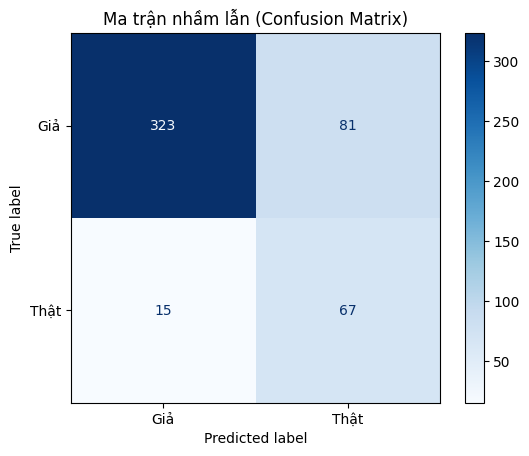

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
df = pd.read_csv("/content/drive/MyDrive/dataset/news/qwen_prediction_fewshot.csv")

# Giả sử label và predict là kiểu số nguyên (0 hoặc 1)
y_true = df['label']
y_pred = df['predict']

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# In kết quả ra màn hình
print("🔹 Đánh giá mô hình:")
print(f"  - Accuracy : {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall   : {recall:.4f}")
print(f"  - F1-score : {f1:.4f}")

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Giả', 'Thật'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
plt.show()


In [ ]:
df.count()

,0
user_name,486
post_message,486
timestamp_post,486
num_like_post,486
num_comment_post,486
num_share_post,486
label,486
predict,486


🔹 ROC-AUC Score: 0.8083


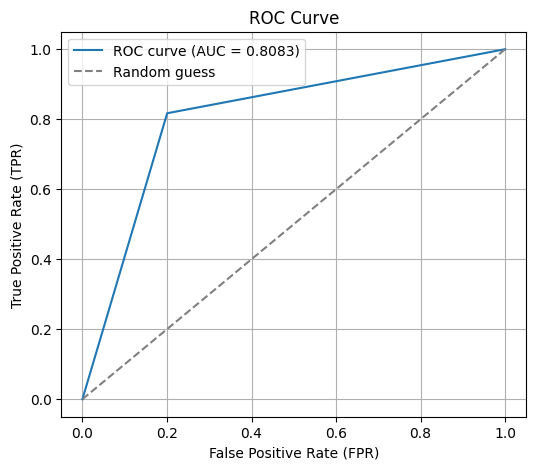

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = df['label']          # nhãn thật
y_score = df['predict']  # xác suất dự đoán (cột này phải có)

# Tính ROC và AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

print(f"🔹 ROC-AUC Score: {auc_score:.4f}")

# Vẽ đường ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
# print("Trainable params:", trainable_params)
# print("Số trainable params:", len(trainable_params))
